In [34]:
import sys
sys.path.append("../models/")
from model import Net
from easydict import EasyDict
import yaml
config_path = "/home/qhy/Reserach/AICAS/config/742-stage-1_3_4_1_1-ratio-0.5_0.5_1.0_0.625_0.375-op-vgg_repvgg_vgg_vgg_repvgg-pool-False_True_False_True_True_True-pool_type-None_maxpool_None_maxpool_avgpool_avgpool-cifar10.yaml"
config = EasyDict(yaml.full_load(open(config_path)))
m = Net(config,10)


FileNotFoundError: [Errno 2] No such file or directory: '/home/qhy/Reserach/AICAS/config/742-stage-1_3_4_1_1-ratio-0.5_0.5_1.0_0.625_0.375-op-vgg_repvgg_vgg_vgg_repvgg-pool-False_True_False_True_True_True-pool_type-None_maxpool_None_maxpool_avgpool_avgpool-cifar10.yaml'

In [1]:
# np.save("/home/qhy/Reserach/AICAS/predictor/dataset/code.npy",np.array(code_dataset))
# np.save("/home/qhy/Reserach/AICAS/predictor/dataset/acc.npy",np.array(acc_dataset))
import numpy as np
# code_dataset = np.load("/home/qhy/Reserach/AICAS/predictor/dataset/code_510-989.npy").astype(np.float32)
# # acc_dataset = np.load("/home/qhy/Reserach/AICAS/predictor/dataset/acc_8_510-989.npy").astype(np.float32)
# acc_dataset = np.load("/home/qhy/Reserach/AICAS/predictor/dataset/acc_32_510-989.npy").astype(np.float32)
code_dataset = np.load("/home/qhy/Reserach/AICAS/predictor/dataset/code_510-989-add-new-searched.npy").astype(np.float32)
acc_dataset = np.load("/home/qhy/Reserach/AICAS/predictor/dataset/acc_32_510-989-add-new-searched.npy").astype(np.float32)



### Add New Pair

In [ ]:
"""import sys
import numpy as np
import os
import tqdm
import torch
from easydict import EasyDict
import yaml
def encode_new(num,config):
    mapping_op = {'repvgg':0,'vgg':1}
    mapping_pool = {'maxpool':0,'avgpool':1,"None":2}
    code = []
    if config['model']["stage_ratio"] != None:
        code += config['model']["stage_ratio"]
    else:
        print("Error in stage ration")
    
    if config['model']['op_type'] != None:
        code += [mapping_op[i] for i in config['model']['op_type']]
    else:
        print("Error in op type")
    
    mapping_pool = {"maxpool":0,"avgpool":1,None:2}
    if config['model']['pool_type'] != None:
        code += [mapping_pool[i] for i in config['model']['pool_type']]
    else:
        print("Error in maxpool")
    if config['model']['stage_layer'] != None:
        code += config['model']['stage_layer']
    else:
        print("Error in stage layer")
    assert len(code) == 21,print(num,len(code),code)
    return code

path_searched = os.listdir("/home/qhy/Reserach/AICAS/log/search-best")
start_num = 990
new_acc = []
new_code = []
for p in tqdm.tqdm(path_searched):
    print(p)
    num = int(p.split("-")[0])
    config_path = "/home/qhy/Reserach/AICAS/config/search-best/"+p+'.yaml'
    if num>46 and os.path.exists(config_path):
        config = EasyDict(yaml.full_load(open(config_path)))
        code = encode_new(start_num,config)
        model_path = "/home/qhy/Reserach/AICAS/log/search-best/"+p+'/best_ckpt.pth'
        param = torch.load(model_path)
        acc = param['max_accuracy']
        start_num+=1
        new_acc.append(acc)
        new_code.append(code)
    
new_code_dataset = list(code_dataset) + list(np.array(new_code)*np.array([8]*5+[1]*16))
new_acc_dataset = list(acc_dataset) + new_acc
np.save("/home/qhy/Reserach/AICAS/predictor/dataset/code_510-989-add-new-searched.npy",new_code_dataset)
np.save("/home/qhy/Reserach/AICAS/predictor/dataset/acc_32_510-989-add-new-searched.npy",new_acc_dataset)"""

In [10]:
train_num = 500
train_code_dataset = code_dataset[0:train_num]
test_code_dataset = code_dataset[train_num:]
train_acc_dataset = acc_dataset[0:train_num]
test_acc_dataset = acc_dataset[train_num:]
print(max(train_acc_dataset))
print(max(test_acc_dataset))
print(len(code_dataset))

93.41
92.58
514


In [17]:
from sklearn import metrics
import sys
import torch
sys.path.append("..")
from predictor.mlp import fit
train_num = 400
train_code_dataset = code_dataset[0:train_num]
test_code_dataset = code_dataset[train_num:]
train_acc_dataset = acc_dataset[0:train_num]
test_acc_dataset = acc_dataset[train_num:]
print(max(train_acc_dataset))
print(max(test_acc_dataset))

hyperparams = {
    "input_dims" : 21,
    "num_layers" : 5,
    "layer_width" : [ 40, 80, 40, 20, 10],
    "batch_size" : 100,
    "lr" : 0.01,
    "regularization":0.1,
    "ratio": 0.00001,
    "loss": "mse" #"pair_loss" # "pair_loss" #'mae' "mse"
    
}
R2_test_max = -1
R2_train_max = -1

R2_SUM = -1

for num in range(10):
    train_error,model_trained = fit(hyperparams,train_code_dataset,train_acc_dataset,epochs=500,verbose=0)
    test_pred = []
    for i in test_code_dataset:
        input = torch.tensor(i).to(torch.float32)
        test_pred.append(model_trained(input).detach().numpy())
    test_acc_dataset = np.array(test_acc_dataset)
    test_pred = np.array(test_pred)
    MSE = metrics.mean_squared_error(test_acc_dataset, test_pred)
    R2_test = 1 - (MSE/np.mean((test_pred-np.mean(test_acc_dataset))**2))
    train_pred = []
    for i in train_code_dataset:
        input = torch.tensor(i)
        train_pred.append(model_trained(input).detach().numpy())
    train_acc_dataset = np.array(train_acc_dataset)
    train_pred = np.array(train_pred)
    MSE = metrics.mean_squared_error(train_acc_dataset, train_pred)
    R2_train = 1 - (MSE/np.mean((train_pred-np.mean(train_acc_dataset))**2))
    
    if R2_test_max<R2_test:
        R2_test_max = R2_test
        better_model_test = model_trained
        print(num,train_error,R2_test_max)
    if R2_train_max<R2_train:
        R2_train_max = R2_train
        better_model_train = model_trained
        print(num,train_error,R2_train_max)
    if R2_SUM <(R2_test+R2_train) :
        better_model_sum = model_trained
        R2_SUM  = R2_test+R2_train
        print(num,train_error,R2_SUM)
    # print(train_error, R2_test,R2_test_max,R2_train,R2_train_max)
    # print(train_error,R2_SUM)

93.11
93.41


100%|██████████| 500/500 [00:05<00:00, 89.73it/s] 


0 0.93093324 0.08682447671890259
0 0.93093324 0.8078515976667404
0 0.93093324 0.894676074385643


100%|██████████| 500/500 [00:05<00:00, 97.44it/s] 


2 0.98364043 0.8093133121728897


100%|██████████| 500/500 [00:05<00:00, 97.76it/s] 


3 0.49854547 0.128645658493042
3 0.49854547 0.9343949928879738
3 0.49854547 1.0630406513810158


100%|██████████| 500/500 [00:05<00:00, 93.31it/s]


6 0.69491094 0.14910131692886353


100%|██████████| 500/500 [00:05<00:00, 97.17it/s] 


8 0.44329947 0.9463204517960548


100%|██████████| 500/500 [00:05<00:00, 99.09it/s] 


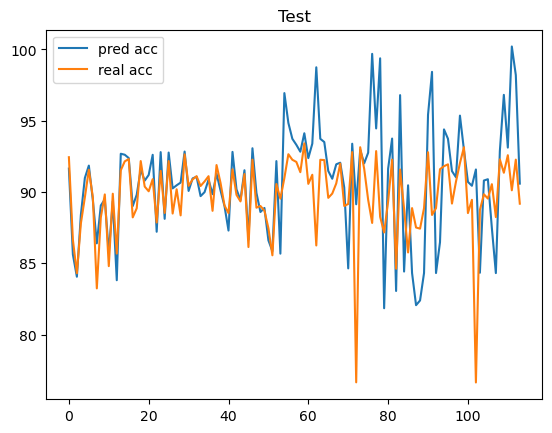

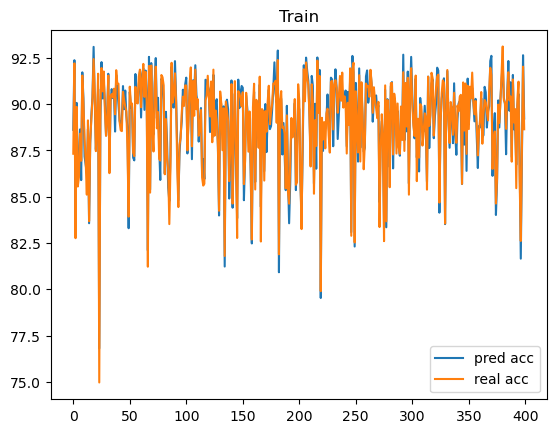

====TRAIN====
std 3.4167047
mean 0.01227059
MSE 0.3786883
RMSE 0.61537655595284
MAE 0.49854562
MAPE 0.0056334394
R2 0.9343949928879738
spearmanr R 0.954074712304128
spearmanr P 1.852052731997301e-210
====TEST====
std 4.5511427
mean 1.6342924
MSE 13.794214
RMSE 3.7140563066083456
MAE 2.2931998
MAPE 0.026138106
R2 0.128645658493042
spearmanr R 0.6852347268841761
spearmanr P 4.135825600963823e-17
diff2 = 2221.6315789473683


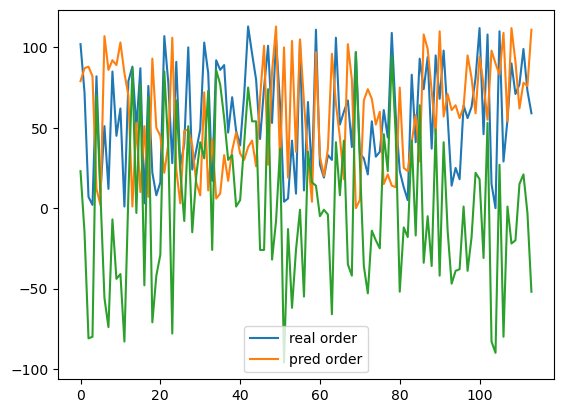

In [18]:
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
model_trained = better_model_sum
test_pred = []
for i in test_code_dataset:
    input = torch.tensor(i)
    test_pred.append(model_trained(input).detach().numpy())
plt.plot(range(len(test_pred)),test_pred,label="pred acc")
plt.plot(range(len(test_pred)),test_acc_dataset,label="real acc")
plt.legend()
plt.title("Test")
plt.show()

train_pred = []
for i in train_code_dataset:
    input = torch.tensor(i)
    train_pred.append(model_trained(input).detach().numpy())
plt.plot(range(len(train_pred)),train_pred,label="pred acc")
plt.plot(range(len(train_pred)),train_acc_dataset,label="real acc")
plt.legend()
plt.title("Train")
plt.show()
print("====TRAIN====")
train_acc_dataset = np.array(train_acc_dataset)
train_pred = np.array(train_pred)
MSE = metrics.mean_squared_error(train_acc_dataset, train_pred)
RMSE = metrics.mean_squared_error(train_acc_dataset, train_pred)**0.5
MAE = metrics.mean_absolute_error(train_acc_dataset, train_pred)
MAPE = metrics.mean_absolute_percentage_error(train_acc_dataset, train_pred)
r_train,p_train = stats.spearmanr(train_acc_dataset, train_pred)
R2_train = 1 - (MSE/np.mean((train_pred-np.mean(train_acc_dataset))**2))
print("std",np.std(np.array(train_pred)-train_acc_dataset))
print("mean",np.mean(np.array(train_pred)-train_acc_dataset))
print("MSE", MSE)
print("RMSE", RMSE)
print("MAE",MAE)
print("MAPE",MAPE)
print("R2",R2_train)
print("spearmanr R",r_train)
print("spearmanr P",p_train)

print("====TEST====")
test_acc_dataset = np.array(test_acc_dataset)
test_pred = np.array(test_pred)
MSE = metrics.mean_squared_error(test_acc_dataset, test_pred)
RMSE = metrics.mean_squared_error(test_acc_dataset, test_pred)**0.5
MAE = metrics.mean_absolute_error(test_acc_dataset, test_pred)
MAPE = metrics.mean_absolute_percentage_error(test_acc_dataset, test_pred)
R2_test = 1 - (MSE/np.mean((test_pred-np.mean(test_acc_dataset))**2))
r_test,p_test = stats.spearmanr(test_acc_dataset, test_pred)

print("std",np.std(np.array(test_pred)-np.array(train_acc_dataset)))
print("mean",np.mean(np.array(test_pred)-np.array(train_acc_dataset)))
print("MSE", MSE)
print("RMSE", RMSE)
print("MAE",MAE)
print("MAPE",MAPE)
print("R2",R2_test)
print("spearmanr R",r_test)
print("spearmanr P",p_test)

real_order = test_acc_dataset.argsort()
pred_order = test_pred.squeeze().argsort()
plt.plot(range(pred_order.shape[0]),real_order,label="real order")
plt.plot(range(pred_order.shape[0]),pred_order,label="pred order")
plt.legend()
plt.plot(range(pred_order.shape[0]),real_order-pred_order,label="diff")
diff2 = ((real_order-pred_order)**2).sum()/pred_order.shape[0]
print("diff2 =",diff2)



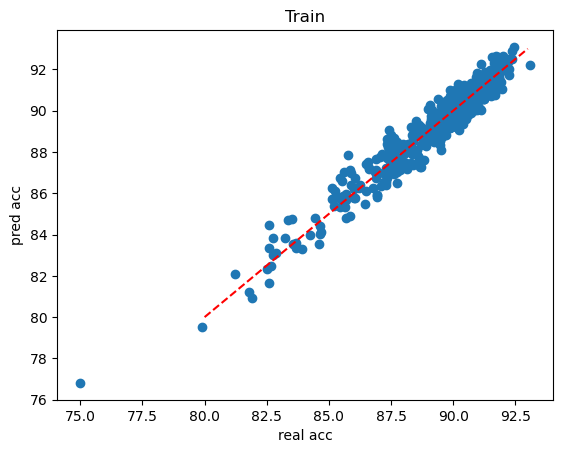

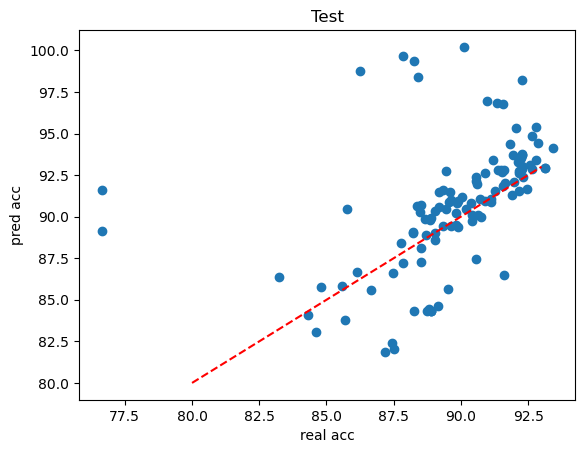

In [19]:
plt.scatter(train_acc_dataset,train_pred)
plt.plot(range(80,94),range(80,94),'--',c="r")
plt.title("Train")
plt.xlabel("real acc")
plt.ylabel("pred acc")
plt.show()
plt.scatter(test_acc_dataset,test_pred)
plt.plot(range(80,94),range(80,94),'--',c="r")
plt.title("Test")
plt.xlabel("real acc")
plt.ylabel("pred acc")
plt.show()

In [20]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig, (ax0,ax1) = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))
# scatter = ax0.hexbin(test_acc_dataset, test_pred.squeeze() ,bins='log',gridsize=100,cmap='Spectral_r')
# hb = ax1.hexbin(test_acc_dataset, (test_pred.squeeze()-test_acc_dataset) ,bins='log',gridsize=100,cmap='Spectral_r')

# cb = fig.colorbar(hb,ax=ax0,label="counts")
# # divider = make_axes_locatable(ax)
# # cax = divider.append_axes("right", size="5%", pad=0.1)
# # cbar = fig.colorbar(scatter, cax=cax, label='frequency')



In [21]:
import os
save_model = {
    "hyperparams":hyperparams,
    "model":model_trained.state_dict(),
    "R2-train": R2_train,
    "R2-test": R2_test,
    "R-train":r_train,
    "R-test":r_test
}
save_path = "/home/qhy/Reserach/AICAS/predictor/MLP/cifar10/"+"loss-"+hyperparams['loss']+"-ratio-"+str(hyperparams['ratio'])+"-input_dims-"+str(hyperparams["input_dims"])+"-train_num-"+str(train_num)+'-num_layers-'+str(hyperparams["num_layers"])+'-layer_width-'+'_'.join([str(i) for i in hyperparams["layer_width"]]) + '-lr-'+str(hyperparams['lr'])+'-regular-'+str(hyperparams['regularization'])+"-r-train-"+str(round(r_train,4))+"-r-test-"+str(round(r_test,4))+"-diff2-"+str(round(diff2,4))+'.pth'
if os.path.exists(save_path):
    save_path = save_path.replace(".pth","-1.pth")
torch.save(save_model,save_path)
save_path

'/home/qhy/Reserach/AICAS/predictor/MLP/cifar10/loss-mse-ratio-1e-05-input_dims-21-train_num-400-num_layers-5-layer_width-40_80_40_20_10-lr-0.01-regular-0.1-r-train-0.9541-r-test-0.6852-diff2-2221.6316.pth'

In [72]:
save_path

'/home/qhy/Reserach/AICAS/predictor/MLP/loss-pair+mse-input_dims-21-train_num-300-num_layers-5-layer_width-40_80_40_20_10-lr-0.1-regular-0.1-r-train-0.9526-r-test-0.9256-diff2-3472.1184.pth'

In [27]:
# 设计一个实际顺序与预测顺序的比较函数


In [24]:
import numpy as np
x = np.array([2,1,4,5,7,3,6])
y = x.argsort()
print (y[1], y[-1])


0 4


In [30]:
real_order = test_acc_dataset.argsort()
pred_order = test_pred.squeeze().argsort()
plt.plot(range(pred_order.shape[0]),real_order,label="real order")
plt.plot(range(pred_order.shape[0]),pred_order,label="pred order")
plt.legend()
plt.plot(range(pred_order.shape[0]),real_order-pred_order,label="pred order")
print(((real_order-pred_order)**2).sum())